In [66]:
from langchain_core.messages import BaseMessage,AIMessage, HumanMessage
from langchain_core.documents import Document
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
from langchain_core.retrievers import BaseRetriever
from langchain_community.tools import TavilySearchResults
from langchain_community.document_loaders import PyPDFLoader
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings,ChatOpenAI
from langchain_experimental.text_splitter import SemanticChunker
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode
from langgraph.graph import END, StateGraph
from langgraph.types import Command
from typing import Annotated, Literal, TypedDict, Sequence, List
from pydantic import BaseModel,Field
from operator import itemgetter
import os
from dotenv import load_dotenv
load_dotenv()
#langsmith
tavily_tool = TavilySearchResults(search_depth='advanced',max_results=5)
search=[tavily_tool]

In [67]:
llm = ChatOpenAI(model="gpt-5-nano-2025-08-07")
llm = llm.bind_tools(tools=search)
embedder = OpenAIEmbeddings()

In [68]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    file_path: str
    documents: List[Document]
    retriever: BaseRetriever
class GradeDocuments(BaseModel):
    binary_score: str = Field(description="Documents are relevant to the question, 'yes' or 'no'")

structured_llm_grader = llm.with_structured_output(GradeDocuments)

def format_docs(docs):
    return "\n\n".join([d.page_content for d in docs])

In [69]:
def retrieve(state: AgentState)-> Command[Literal['router']]:
    
    file_path = state['file_path']
    if file_path != '':
        if not os.path.exists(file_path):
            return {"messages": [AIMessage(content="File not found.")]}
        
        loader = PyPDFLoader(file_path)
        docs = loader.load()
        
        
        text_splitter = SemanticChunker(
            embedder, 
            breakpoint_threshold_type="standard_deviation",
            breakpoint_threshold_amount=1.5
        )
        
        splits = text_splitter.split_documents(docs)
        
        vectorstore = Chroma.from_documents(
            documents=splits, 
            embedding=embedder
        )
        
        retriever = vectorstore.as_retriever()
    
        return Command(goto='router', update={'retriever':retriever,'documents': docs})
    
    else: return Command(goto='router', update={'retriever':'','documents': ''})

In [70]:
def grade_documents(state: AgentState) -> Command[Literal['RAG', 'search_tool']]:
    question = state["messages"][-1].content
    documents = state['documents']
    
    # If no docs, force the LLM to generate a search tool call
    if not documents:
        # We bind the tool and FORCE it to be called using tool_choice
        llm_with_forced_search = llm.bind_tools(search, tool_choice="tavily_search_results_json")
        msg = llm_with_forced_search.invoke(state["messages"])
        return Command(goto='search_tool', update={'messages': [msg]})
    
    grade_prompt = f"""You are a grader assessing relevance of a retrieved document to a user query.
    Retrieved documents: {documents}
    User query: {question}
    If the document contains keyword(s) or semantic meaning related to the user query, grade it as relevant.
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the query."""
    
    scoring = structured_llm_grader.invoke(grade_prompt)
    
    if scoring.binary_score == "yes":
        return Command(goto='RAG')
    else:
        return Command(goto='search_tool', update={'messages': [msg]})

In [71]:
def process_uploaded_file(state:AgentState) -> Command[Literal['router',END]]:
    """Process uploaded files for suitable output"""
    
    file_path = state['file_path']
    retriever = state['retriever']
    
    if os.path.exists(file_path):
        
        template = """Answer based strictly on the context below:
        {context}

        Question: {question}
        """
        prompt = ChatPromptTemplate.from_template(template)
        
        
        rag_chain = (
            # Take the input dictionary and ADD a 'context' key to it
            RunnablePassthrough.assign(
                context=itemgetter("question") | retriever | format_docs
            )
            | prompt
            | llm
            | StrOutputParser()
        )
        query_dictionary = state['messages'][-1].content
        result = rag_chain.invoke({'question':query_dictionary})
        
        return Command(goto=END, update={'messages': result})
        
    else:
        state["messages"].append(AIMessage(content="Please check the file you uploaded exists and isn't corrupted."))
        return Command(goto=END,update={state: state})

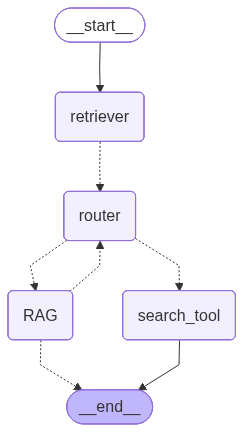

In [72]:
graph=StateGraph(AgentState)
graph.add_node('router', grade_documents)
graph.add_node('RAG', process_uploaded_file)
graph.add_node('retriever', retrieve)
tool = ToolNode(search)
graph.add_node('search_tool',tool)
graph.set_entry_point('retriever')
app=graph.compile()

app

In [73]:
app.invoke({'messages':'what is in the projects','documents':[],'file_path':r"E:\toz\1729169643560.pdf"})

{'messages': [HumanMessage(content='what is in the projects', additional_kwargs={}, response_metadata={}, id='f2c12cc3-c2dd-4899-bbee-787dc5be3e88'),
  HumanMessage(content='Projects\n\n- Case Master\n  - Technologies: Typescript, Next.js, TailwindCSS, Shadcn UI, Stripe Payment, Kinde, Prisma\n  - Description: Developed an e-commerce platform allowing users to create and customize high-quality phone cases by uploading their own photos. The website supports modern iPhone models and offers seamless customization, preview, and purchase experiences.\n  - Live link: https://case-master-pearl.vercel.app\n  - Source: https://github.com/MekuXXX/Case_Master\n\n- Aora AI\n  - Technologies: Typescript, React Native, Expo, NativeWind, AppWrite\n  - Description: Developed a cross-platform mobile application with authentication, onboarding, and user profile management. Implemented smooth navigation with Expo Router.\n  - Source: https://github.com/MekuXXX/Aora_AI_RN\n\n- Ecomvision Dashboard\n  - Te